In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = r'C:\Users\siger\OneDrive\Рабочий стол\Сосиськи кейс\кейс_аналитика.xlsx'

promo_addresses = pd.read_excel(path, sheet_name='Адреса')
dec_2022 = pd.read_excel(path, sheet_name='Dec 2022')
jan_2023 = pd.read_excel(path, sheet_name='Jan 2023')
mapping = pd.read_excel(path, sheet_name='mapping')

In [ ]:
#информация о таблицах в книге
def peek(df, name):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("columns:", df.columns.tolist())
    display(df.head(3))

peek(promo_addresses, "promo_addresses")
peek(dec_2022, "dec_2022")
peek(jan_2023, "jan_2023")



=== promo_addresses ===
shape: (43, 1)
columns: ['Москва Гурьевский пр-д 25']


,Москва Гурьевский пр-д 25
0,Москва Мячковский бульвар 13
1,Москва Люблинская 126
2,Москва Люблинская 108



=== dec_2022 ===
shape: (533831, 7)
columns: ['Месяц', 'Календарь День', 'Магазин Адрес', 'Магазин Город', 'Продукт Производитель Наименование', 'Продукт Наименование', 'Sum([Операция Продажи, кг])']


,Месяц,Календарь День,Магазин Адрес,Магазин Город,Продукт Производитель Наименование,Продукт Наименование,"Sum([Операция Продажи, кг])"
0,2022-12,1,"101000, москва г, чистопрудный б-р, дом 12а, с...",Москва г,Останкино,ОСТАН.Сосиски ФИЛЕЙНЫЕ м.пт.вар.1с 400г,0.0
1,2022-12,2,"101000, москва г, чистопрудный б-р, дом 12а, с...",Москва г,Останкино,ОСТАН.Сосиски ФИЛЕЙНЫЕ м.пт.вар.1с 400г,0.0
2,2022-12,3,"101000, москва г, чистопрудный б-р, дом 12а, с...",Москва г,Останкино,ОСТАН.Сосиски ФИЛЕЙНЫЕ м.пт.вар.1с 400г,0.0



=== jan_2023 ===
shape: (512419, 7)
columns: ['Месяц', 'Календарь День', 'Магазин Адрес', 'Магазин Город', 'Продукт Производитель Наименование', 'Продукт Наименование', 'Sum([Операция Продажи, кг])']


,Месяц,Календарь День,Магазин Адрес,Магазин Город,Продукт Производитель Наименование,Продукт Наименование,"Sum([Операция Продажи, кг])"
0,2023-01,1,"101000, москва г, чистопрудный б-р, дом 12а, с...",Москва г,Останкино,ОСТАН.Сосиски ФИЛЕЙНЫЕ м.пт.вар.1с 400г,0.0
1,2023-01,2,"101000, москва г, чистопрудный б-р, дом 12а, с...",Москва г,Останкино,ОСТАН.Сосиски ФИЛЕЙНЫЕ м.пт.вар.1с 400г,0.0
2,2023-01,3,"101000, москва г, чистопрудный б-р, дом 12а, с...",Москва г,Останкино,ОСТАН.Сосиски ФИЛЕЙНЫЕ м.пт.вар.1с 400г,0.0


In [10]:
promo_addresses = pd.read_excel(path, sheet_name="Адреса", header=None)
promo_addresses = promo_addresses.rename(columns={0: "promo_addr"})
promo_addresses = promo_addresses.dropna(subset=["promo_addr"])
promo_addresses["promo_addr"] = promo_addresses["promo_addr"].astype(str).str.strip()
promo_addresses.head()


,promo_addr
0,Москва Гурьевский пр-д 25
1,Москва Мячковский бульвар 13
2,Москва Люблинская 126
3,Москва Люблинская 108
4,Москва Ясеневая 31


In [39]:
jan = jan_2023.copy()

test_set = set(mapping["CRM_addr"].dropna().astype(str).str.strip().str.lower())
jan["is_test"] = jan["Магазин Адрес"].astype(str).str.strip().str.lower().isin(test_set)

jan["is_test"].value_counts()


is_test
False    506751
True       5668
Name: count, dtype: int64

In [ ]:
#проверка соответствия адресов из списка промо-адресов с выгрузкой из CRM
jan = jan_2023.copy()
jan["is_test"] = jan["Магазин Адрес"].isin(set(mapping["CRM_addr"].dropna()))

jan["period"] = (jan["Календарь День"] <= 11).map({True: "pre", False: "post"})

agg = (
    jan.groupby(["is_test", "period"], as_index=False)["Sum([Операция Продажи, кг])"]
       .sum()
       .rename(columns={"Sum([Операция Продажи, кг])": "sales_kg"})
)

agg


,is_test,period,sales_kg
0,False,post,1087447.266
1,False,pre,630730.044
2,True,post,15588.720
3,True,pre,9394.380


In [ ]:
#проверка показателей в тестовой и контрольной группе
jan = jan_2023.copy()
jan["is_test"] = jan["Магазин Адрес"].isin(set(mapping["CRM_addr"].dropna()))
jan["period"] = (jan["Календарь День"] <= 11).map({True: "pre", False: "post"})

summary = (
    jan.groupby(["is_test", "period"])
      .agg(
          sales_kg=("Sum([Операция Продажи, кг])", "sum"),
          days=("Календарь День", "nunique"),
          stores=("Магазин Адрес", "nunique"),
      )
      .reset_index()
)

summary["kg_per_day"] = summary["sales_kg"] / summary["days"]
summary["kg_per_store_day"] = summary["sales_kg"] / (summary["days"] * summary["stores"])

summary


,is_test,period,sales_kg,days,stores,kg_per_day,kg_per_store_day
0,False,post,1087447.266,20,3362,54372.363300,16.172624
1,False,pre,630730.044,11,3347,57339.094909,17.131489
2,True,post,15588.720,20,38,779.436000,20.511474
3,True,pre,9394.380,11,38,854.034545,22.474593


In [ ]:
# расчет ключевой метрики DiD по всем магазинам
p = summary.pivot(index="is_test", columns="period", values="kg_per_store_day")

delta_test = p.loc[True, "post"] - p.loc[True, "pre"]
delta_ctrl = p.loc[False, "post"] - p.loc[False, "pre"]
did = delta_test - delta_ctrl

delta_test, delta_ctrl, did


(np.float64(-1.96311961722488),
 np.float64(-0.9588649463372363),
 np.float64(-1.0042546708876436))

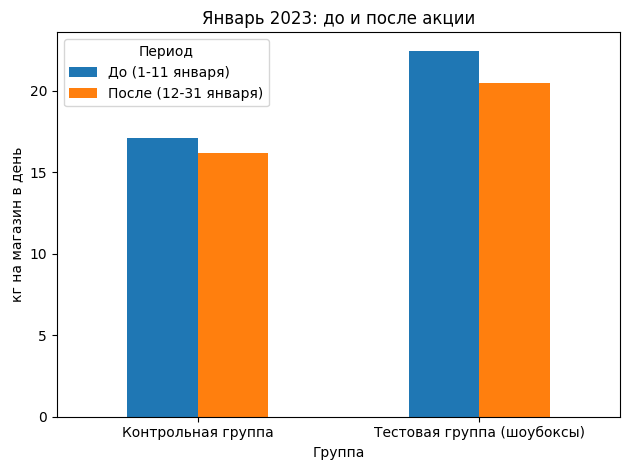

In [ ]:
#график продаж по группам общий
plot_df = summary.copy()
plot_df["Группа"] = plot_df["is_test"].map({True: "Тестовая группа (шоубоксы)", False: "Контрольная группа"})
plot_df["Период"] = plot_df["period"].map({'pre': 'До (1-11 января)', 'post': 'После (12-31 января)'})
plot_df = plot_df.pivot(index = "Группа", columns="Период", values="kg_per_store_day")[['До (1-11 января)', 'После (12-31 января)']]

ax = plot_df.plot(kind="bar")
ax.set_ylabel("кг на магазин в день")
ax.set_title("Январь 2023: до и после акции")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


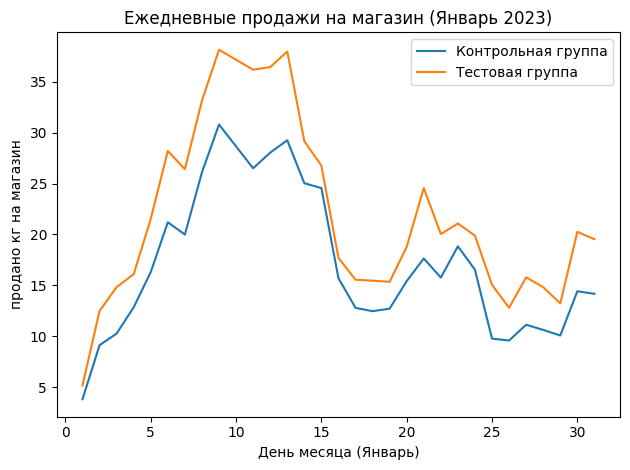

In [ ]:
#график тренда продаж по дням с исключением провала продаж 10 января общий
jan2 = jan[jan["Календарь День"] != 10].copy()

daily = (
    jan2.groupby(["Календарь День", "is_test"])
        .agg(
            sales_kg=("Sum([Операция Продажи, кг])", "sum"),
            stores=("Магазин Адрес", "nunique")
        )
        .reset_index()
)
daily["kg_per_store"] = daily["sales_kg"] / daily["stores"]
daily["group"] = daily["is_test"].map({True:"Тестовая группа", False:"Контрольная группа"})

for g, gdf in daily.groupby("group"):
    plt.plot(gdf["Календарь День"], gdf["kg_per_store"], label=g)

plt.xlabel("День месяца (Январь)")
plt.ylabel("продано кг на магазин")
plt.title("Ежедневные продажи на магазин (Январь 2023)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#разница между средним DiD после акции и до акции
daily = (
    jan.groupby(["Календарь День", "is_test"])
       .agg(
           sales_kg=("Sum([Операция Продажи, кг])", "sum"),
           stores=("Магазин Адрес", "nunique")
       )
       .reset_index()
)
daily["kg_per_store"] = daily["sales_kg"] / daily["stores"]

d = daily.pivot(index="Календарь День", columns="is_test", values="kg_per_store").dropna()
d = d.rename(columns={False: "control", True: "test"})
d["diff"] = d["test"] - d["control"]

pre = d.loc[d.index <= 11, "diff"].to_numpy()
post = d.loc[d.index >= 12, "diff"].to_numpy()

did_point = post.mean() - pre.mean()
did_point


-1.0459324823642229


In [ ]:
#оценка статистической значимости по доверительному интервалу
rng = np.random.default_rng(42)
B = 20000

boot = np.empty(B)
for b in range(B):
    pre_b = rng.choice(pre, size=len(pre), replace=True)
    post_b = rng.choice(post, size=len(post), replace=True)
    boot[b] = post_b.mean() - pre_b.mean()

ci_low, ci_high = np.quantile(boot, [0.025, 0.975])
ci_low, ci_high


(np.float64(-2.6572031537768614), np.float64(0.5496046931571403))

In [ ]:
#оценка по целевому SKU

TARGET = "ОСТАНКИНО Сосис.В ДОМ.МОЛ.вар.кат.Б 300г"

jan_t = jan_2023[jan_2023["Продукт Наименование"].eq(TARGET)].copy()

jan_t["is_test"] = jan_t["Магазин Адрес"].isin(set(mapping["CRM_addr"].dropna()))

jan_t["period"] = (jan_t["Календарь День"] <= 11).map({True: "pre", False: "post"})

summary_t = (
    jan_t.groupby(["is_test", "period"])
         .agg(
             sales_kg=("Sum([Операция Продажи, кг])", "sum"),
             days=("Календарь День", "nunique"),
             stores=("Магазин Адрес", "nunique"),
         )
         .reset_index()
)
summary_t["kg_per_store_day"] = summary_t["sales_kg"] / (summary_t["days"] * summary_t["stores"])

summary_t

,is_test,period,sales_kg,days,stores,kg_per_store_day
0,False,post,80936.28,20,3326,1.216721
1,False,pre,52168.32,11,3314,1.431073
2,True,post,1476.36,20,38,1.942579
3,True,pre,731.16,11,38,1.749187


In [ ]:
#разница между средним DiD после акции и до акции + расчет доверительного интервала (нижней и верхней границы)
daily_t = (
    jan_t.groupby(["Календарь День", "is_test"])
         .agg(
             sales_kg=("Sum([Операция Продажи, кг])", "sum"),
             stores=("Магазин Адрес", "nunique")
         )
         .reset_index()
)
daily_t["kg_per_store"] = daily_t["sales_kg"] / daily_t["stores"]

d = daily_t.pivot(index="Календарь День", columns="is_test", values="kg_per_store").dropna()
d = d.rename(columns={False: "control", True: "test"})
d["diff"] = d["test"] - d["control"]

pre = d.loc[d.index <= 11, "diff"].to_numpy()
post = d.loc[d.index >= 12, "diff"].to_numpy()

did_point = post.mean() - pre.mean()

rng = np.random.default_rng(42)
B = 20000
boot = np.empty(B)
for b in range(B):
    boot[b] = rng.choice(post, len(post), True).mean() - rng.choice(pre, len(pre), True).mean()

ci_low, ci_high = np.quantile(boot, [0.025, 0.975])

did_point, (ci_low, ci_high)

(np.float64(0.36968002546968),
 (np.float64(-0.01607222897531137), np.float64(0.7777345043052283)))

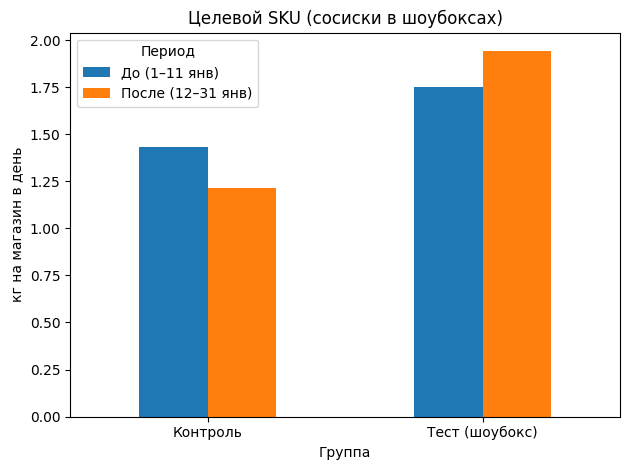

In [ ]:
#график продаж по группам по целевому SKU
TARGET = "ОСТАНКИНО Сосис.В ДОМ.МОЛ.вар.кат.Б 300г"

jan_t = jan_2023[jan_2023["Продукт Наименование"].eq(TARGET)].copy()
jan_t["is_test"] = jan_t["Магазин Адрес"].isin(set(mapping["CRM_addr"].dropna()))
jan_t["period"] = (jan_t["Календарь День"] <= 11).map({True: "До (1–11 янв)", False: "После (12–31 янв)"})

summary_t = (
    jan_t.groupby(["is_test", "period"])
         .agg(
             sales_kg=("Sum([Операция Продажи, кг])", "sum"),
             days=("Календарь День", "nunique"),
             stores=("Магазин Адрес", "nunique"),
         )
         .reset_index()
)
summary_t["kg_per_store_day"] = summary_t["sales_kg"] / (summary_t["days"] * summary_t["stores"])

plot_df = summary_t.copy()
plot_df["Группа"] = plot_df["is_test"].map({True: "Тест (шоубокс)", False: "Контроль"})
plot_df["Период"] = plot_df["period"]
plot_df = plot_df.pivot(index="Группа", columns="Период", values="kg_per_store_day")[["До (1–11 янв)", "После (12–31 янв)"]]

ax = plot_df.plot(kind="bar")
ax.set_ylabel("кг на магазин в день")
ax.set_title("Целевой SKU (сосиски в шоубоксах)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


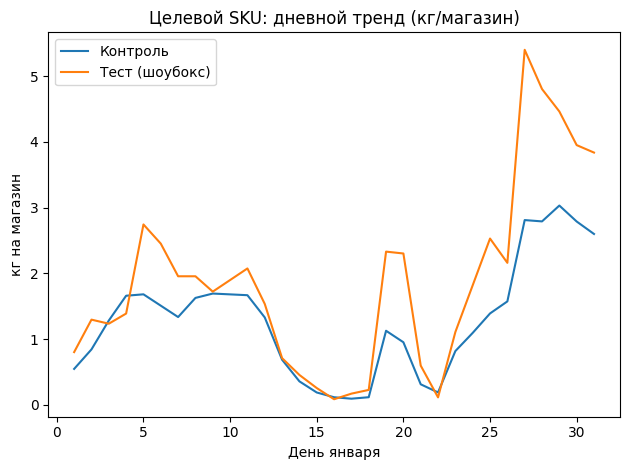

In [ ]:
#график тренда продаж по дням с исключением провала продаж 10 января по целевому SKU
jan_t = jan_t[jan_t["Календарь День"] != 10].copy()

daily_t = (
    jan_t.groupby(["Календарь День", "is_test"])
         .agg(
             sales_kg=("Sum([Операция Продажи, кг])", "sum"),
             stores=("Магазин Адрес", "nunique")
         )
         .reset_index()
)
daily_t["kg_per_store"] = daily_t["sales_kg"] / daily_t["stores"]
daily_t["Группа"] = daily_t["is_test"].map({True: "Тест (шоубокс)", False: "Контроль"})

for g, gdf in daily_t.groupby("Группа"):
    plt.plot(gdf["Календарь День"], gdf["kg_per_store"], label=g)

plt.xlabel("День января")
plt.ylabel("кг на магазин")
plt.title("Целевой SKU: дневной тренд (кг/магазин)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#сводная таблица всех основных показателей
def did_ci_by_days(df, value_col="Sum([Операция Продажи, кг])", B=20000, seed=42):
    daily = (
        df.groupby(["Календарь День", "is_test"])
          .agg(sales_kg=(value_col, "sum"),
               stores=("Магазин Адрес", "nunique"))
          .reset_index()
    )
    daily["kg_per_store"] = daily["sales_kg"] / daily["stores"]

    d = daily.pivot(index="Календарь День", columns="is_test", values="kg_per_store").dropna()
    d = d.rename(columns={False: "control", True: "test"})
    d["diff"] = d["test"] - d["control"]

    pre = d.loc[d.index <= 11, "diff"].to_numpy()
    post = d.loc[d.index >= 12, "diff"].to_numpy()

    did_point = post.mean() - pre.mean()

    rng = np.random.default_rng(seed)
    boot = np.empty(B)
    for b in range(B):
        boot[b] = rng.choice(post, len(post), True).mean() - rng.choice(pre, len(pre), True).mean()

    ci_low, ci_high = np.quantile(boot, [0.025, 0.975])
    return float(did_point), float(ci_low), float(ci_high)

jan_all = jan_2023.copy()
jan_all["is_test"] = jan_all["Магазин Адрес"].isin(set(mapping["CRM_addr"].dropna()))

TARGET = "ОСТАНКИНО Сосис.В ДОМ.МОЛ.вар.кат.Б 300г"
jan_target = jan_all[jan_all["Продукт Наименование"].eq(TARGET)].copy()

res = []
did, lo, hi = did_ci_by_days(jan_all)
res.append(("Все сосиски Останкино (в Jan)", did, lo, hi))

did, lo, hi = did_ci_by_days(jan_target)
res.append(("Целевой SKU 300г", did, lo, hi))

result_table = pd.DataFrame(res, columns=["Метрика", "DiD (кг/магазин-день)", "CI 2.5%", "CI 97.5%"])
result_table


,Метрика,DiD (кг/магазин-день),CI 2.5%,CI 97.5%
0,Все сосиски Останкино (в Jan),-1.045932,-2.630568,0.531759
1,Целевой SKU 300г,0.369680,-0.016072,0.777735


In [ ]:
#экспорт
out_path = r"C:\Users\siger\OneDrive\Рабочий стол\Сосиськи кейс\showbox_results.xlsx"
result_table.to_excel(out_path, index=False, sheet_name="Summary")

In [ ]:
#Все предшествующие манипуляции для декабря (создание "фона" для январской оценки)
dec_all = dec_2022.copy()
dec_all["is_test"] = dec_all["Магазин Адрес"].isin(set(mapping["CRM_addr"].dropna()))

did_dec_all, lo_dec_all, hi_dec_all = did_ci_by_days(dec_all)
did_dec_all, (lo_dec_all, hi_dec_all)


(-1.238162672461971, (-3.1850897128416333, 0.5729180308431859))

In [72]:
TARGET = "ОСТАНКИНО Сосис.В ДОМ.МОЛ.вар.кат.Б 300г"

dec_target = dec_all[dec_all["Продукт Наименование"].eq(TARGET)].copy()

did_dec_t, lo_dec_t, hi_dec_t = did_ci_by_days(dec_target)
did_dec_t, (lo_dec_t, hi_dec_t)


(0.5290572850692294, (0.18048189066596734, 0.8735689509176281))

In [ ]:
def did_boot_by_days(df, B=20000, seed=42):
    daily = (
        df.groupby(["Календарь День", "is_test"])
          .agg(sales_kg=("Sum([Операция Продажи, кг])", "sum"),
               stores=("Магазин Адрес", "nunique"))
          .reset_index()
    )
    daily["kg_per_store"] = daily["sales_kg"] / daily["stores"]

    d = daily.pivot(index="Календарь День", columns="is_test", values="kg_per_store").dropna()
    d = d.rename(columns={False: "control", True: "test"})
    diff = (d["test"] - d["control"]).to_numpy()
    days = d.index.to_numpy()

    pre = diff[days <= 11]
    post = diff[days >= 12]

    rng = np.random.default_rng(seed)
    boot = np.empty(B)
    for b in range(B):
        boot[b] = rng.choice(post, len(post), True).mean() - rng.choice(pre, len(pre), True).mean()
    return boot

dec_all = dec_2022.copy()
dec_all["is_test"] = dec_all["Магазин Адрес"].isin(set(mapping["CRM_addr"].dropna()))
jan_all = jan_2023.copy()
jan_all["is_test"] = jan_all["Магазин Адрес"].isin(set(mapping["CRM_addr"].dropna()))

boot_jan_all = did_boot_by_days(jan_all)
boot_dec_all = did_boot_by_days(dec_all)

boot_diff_all = boot_jan_all - boot_dec_all
diff_point_all = boot_diff_all.mean()
ci_all = np.quantile(boot_diff_all, [0.025, 0.975])

diff_point_all, tuple(ci_all)

(np.float64(0.18930349937275162),
 (np.float64(-2.8284073908635383), np.float64(3.254993244611249)))

In [74]:
TARGET = "ОСТАНКИНО Сосис.В ДОМ.МОЛ.вар.кат.Б 300г"

boot_jan_t = did_boot_by_days(jan_all[jan_all["Продукт Наименование"].eq(TARGET)].copy())
boot_dec_t = did_boot_by_days(dec_all[dec_all["Продукт Наименование"].eq(TARGET)].copy())

boot_diff_t = boot_jan_t - boot_dec_t
diff_point_t = boot_diff_t.mean()
ci_t = np.quantile(boot_diff_t, [0.025, 0.975])

diff_point_t, tuple(ci_t)


(np.float64(-0.15998949672556737),
 (np.float64(-0.698094472221842), np.float64(0.39207114244999314)))

In [ ]:
#добавление итоговой дельты с декабрем в таблицу с итоговыми данными
df = pd.read_excel(out_path, sheet_name="Summary")
df["ΔDiD Jan−Dec"] = None
df["ΔCI 2.5% Jan−Dec"] = None
df["ΔCI 97.5% Jan−Dec"] = None

mask_all = df["Метрика"].str.contains("Все сосиски", na=False)
mask_target = df["Метрика"].str.contains("Целевой SKU", na=False)

df.loc[mask_all, ["ΔDiD Jan−Dec", "ΔCI 2.5% Jan−Dec", "ΔCI 97.5% Jan−Dec"]] = [
    0.18930349937275162, -2.8284073908635383, 3.254993244611249
]
df.loc[mask_target, ["ΔDiD Jan−Dec", "ΔCI 2.5% Jan−Dec", "ΔCI 97.5% Jan−Dec"]] = [
    -0.15998949672556737, -0.698094472221842, 0.39207114244999314
]

for c in ["ΔDiD Jan−Dec", "ΔCI 2.5% Jan−Dec", "ΔCI 97.5% Jan−Dec"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").round(3)
with pd.ExcelWriter(out_path, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df.to_excel(writer, index=False, sheet_name="Summary")
df

,Метрика,DiD (кг/магазин-день),CI 2.5%,CI 97.5%,ΔDiD Jan−Dec,ΔCI 2.5% Jan−Dec,ΔCI 97.5% Jan−Dec
0,Все сосиски Останкино (в Jan),-1.045932,-2.630568,0.531759,0.189,-2.828,3.255
1,Целевой SKU 300г,0.369680,-0.016072,0.777735,-0.160,-0.698,0.392
